In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import scipy
from scipy.optimize import curve_fit
import matplotlib.colors as colors
from numpy import polyfit, poly1d

In [3]:
def DILILA(t,t_len, dinit,gapinit,gapcrit,gapfin,dcrit,dfin,tinflect):
    numstep1 = gapinit* dcrit* t + gapcrit* dinit*(tinflect -t)
    denomsteps1 = gapinit* t + gapcrit * (tinflect - t)
    numstep2 = gapfin* dcrit*(t_len - t ) + gapcrit* dfin*(t-tinflect)
    denomsteps2 = gapfin*(t_len -t) +gapcrit*(t-tinflect)
    if t>t_len:
        out = dfin
    elif t>tinflect:
        out = numstep2/denomsteps2
    else:
        out = numstep1/denomsteps1
    return out
def Deltafunc(time):
    t = time - Rabi_ramp_time
    if t<0:
        return dinit
    else:
        return DILILA(t,T_DiLILA, dinit,gapinit,gapcrit,gapfin,dcrit,dfin,tinflect)

In [4]:
N = [15,13,7]
data_n_15 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_n.csv',delimiter=',')
data_nn_15 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_nn.csv',delimiter=',')
data_n_13 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_n_13.csv',delimiter=',')
data_nn_13 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_nn_13.csv',delimiter=',')
data_n_7 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_n_7.csv',delimiter=',')
data_nn_7 = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_10_22/data_nn_7.csv',delimiter=',')
data_n_list = [data_n_15,data_n_13,data_n_7]
data_nn_list = [data_nn_15,data_nn_13,data_nn_7]
sweep_params_15 = [0,3, -4, 4, 0.52, 4.4,1.6, 6, 1.68]
sweep_params_13 = [0,3,-5,5,0.664,4.2,1.8,6,1.8545]
sweep_params_7 = [0,5,-5,5,1.06,4.6,1.4,6,2.9091]
sweep_params = [sweep_params_15,sweep_params_13,sweep_params_7]

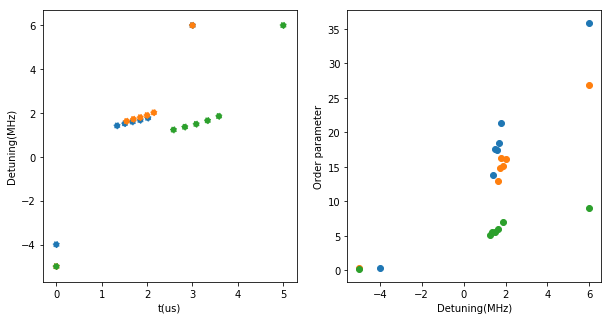

In [26]:
order_list = []
order_err_list = []
det_list = [] 
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for i in range(len(N)):
    data_n = data_n_list[i]
    data_nn = data_nn_list[i]
    t = data_n[0]
    N_t = len(t)
    Nsites = int((len(data_n)-1)/2) 
    n = (data_n[1:Nsites+1]).transpose() #(time,site i)
    n_err = data_n[Nsites+1:].transpose()
    nn = data_nn[0:N_t].reshape(N_t,Nsites,Nsites) # (time,site i, site j)
    nn_err = data_nn[N_t:].reshape(N_t,Nsites,Nsites)
    sign = np.ones(Nsites)
    sign[0::2]=-1
    sign_2D = np.outer(sign,sign)
    Rabi_ramp_time=sweep_params[i][0]
    T_DiLILA = sweep_params[i][1]
    dinit = sweep_params[i][2]
    gapinit = sweep_params[i][3]
    gapcrit = sweep_params[i][4]
    gapfin = sweep_params[i][5]
    dcrit = sweep_params[i][6]
    dfin = sweep_params[i][7]
    tinflect = sweep_params[i][8]
    det = []
    for j in range(len(t)):
        det.append(Deltafunc(t[j]))
#     print(t)
#     print(det)
    det_list.append(det)
    ax[0].scatter(t,det,linestyle = ':')
    order = []
    order_err = []
    for k in range(N_t):
        temp = np.vdot(nn[k],sign_2D)
        temp_err = np.vdot(nn_err[k],sign_2D)
        order.append(temp)
        order_err.append(temp_err)
    order_list.append(order)
    order_err_list.append(order_err)
    ax[1].errorbar(det,order,yerr= order_err,marker = 'o',ls = '')
ax[0].set_ylabel('Detuning(MHz)')
ax[0].set_xlabel('t(us)')
ax[1].set_ylabel('Order parameter')
ax[1].set_xlabel('Detuning(MHz)')
det_list= np.array(det_list)
order_list = np.array(order_list)
order_err_list = np.array(order_err_list)

In [6]:
def func_erf(x,x0,A,B):
    return (scipy.special.erf((x-x0)/B)+1)*A
def func_logistic(x,x0,A,B):
    return A/(1+np.exp(-(x-x0)/B))

15 sites ,fitted crit detuning(MHz)= 1.61 ,fitting error =  0.031
13 sites ,fitted crit detuning(MHz)= 1.602 ,fitting error =  0.104
7 sites ,fitted crit detuning(MHz)= 1.034 ,fitting error =  0.096


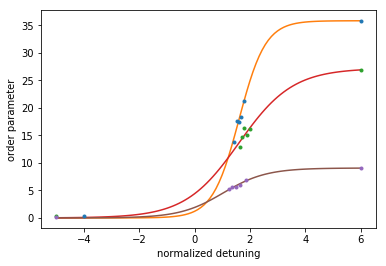

In [21]:
for i in range(len(N)):
    plt.errorbar(det_list[i],order_list[i],yerr=order_err_list[i],ls='',marker='.')
    x_list = np.linspace(-5,6,100)
    #plt.plot(x_list,func_logistic(x_list,1.45,13,0.3))
    #plt.plot(x_list,(scipy.special.erf(x_list)+1)*7)
    p,perr = curve_fit(func_logistic,det_list[i],order_list[i],p0=[1.45,13,0.3])
    print(N[i],'sites',',fitted crit detuning(MHz)=',np.round(p[0],3),',fitting error = ',np.round((np.diag(perr)**0.5)[0],3))

    plt.plot(x_list,func_logistic(x_list,*p))
    plt.xlabel('normalized detuning')
    plt.ylabel('order parameter')
 #   p,perr = curve_fit(func_erf,det_list[i],order_list[i],p0=[1.45,13,0.3])
  #  print(p)
   # plt.plot(x_list,func_erf(x_list,*p))

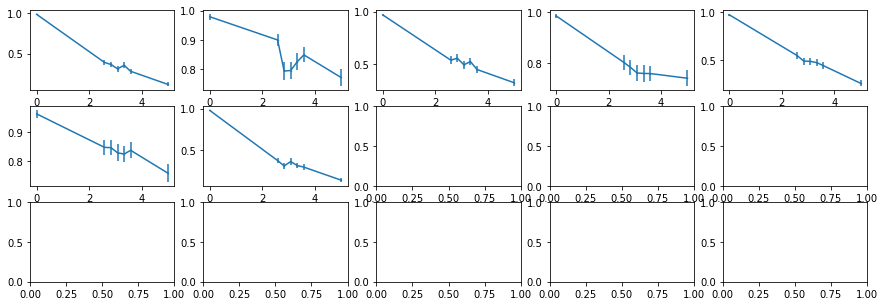

In [9]:
fig, ax = plt.subplots(3, 5, figsize=(15,5))
ms = 1
for i in range(Nsites):
    ax[i//5,i%5].errorbar(t,n[:,i],n_err[:,i],markersize = ms,marker='.')        


8 sites ,fitted crit detuning(MHz)= 1.105 ,fitting error =  0.07


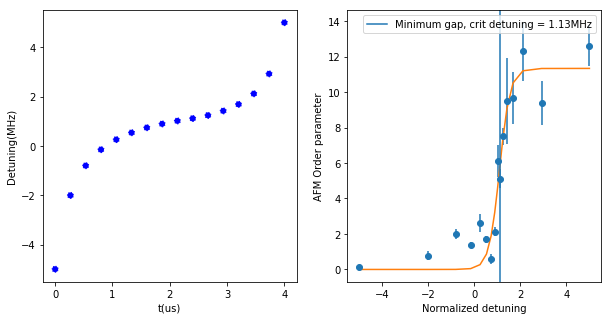

In [39]:
# 8 sites PBC

data_n = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_12_23/data_n_8.csv',delimiter=',')
data_nn = np.loadtxt('C:/msys64/home/wangy/experiment-control/matlab_new/analysis/scripts/1_12_23/data_nn_8.csv',delimiter=',')
t = data_n[0]

N_t = len(t)
Nsites = int((len(data_n)-1)/2) 
n = (data_n[1:Nsites+1]).transpose() #(time,site i)
n_err = data_n[Nsites+1:].transpose()
nn = data_nn[0:N_t].reshape(N_t,Nsites,Nsites) # (time,site i, site j)
nn_err = data_nn[N_t:].reshape(N_t,Nsites,Nsites)
sign = np.ones(Nsites)
sign[0::2]=-1
sign_2D = np.outer(sign,sign)
T_DiLILA = 4
dinit = -5
gapinit = 5.17
gapcrit = 0.6614
gapfin = 3.68
dcrit = 1.13
dfin = 5
tinflect = 2.452
Rabi_ramp_time=0
det = []
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for i in range(len(t)):
    det.append(Deltafunc(t[i]))
ax[0].scatter(t,det,linestyle = ':',color ='blue')
ax[0].set_ylabel('Detuning(MHz)')
ax[0].set_xlabel('t(us)')

order = []
order_err = [] 
for i in range(N_t):
    #print(i)
    temp = np.vdot(nn[i],sign_2D)
    err = np.vdot(nn_err[i],sign_2D)
    
    #print(temp)
    order.append(temp)
    order_err.append(err)

ax[1].errorbar(det,order,order_err,marker = 'o',ls = '')
p,perr = curve_fit(func_logistic,det,order,p0=[1.15,13,0.3])
print(8,'sites',',fitted crit detuning(MHz)=',np.round(p[0],3),',fitting error = ',np.round((np.diag(perr)**0.5)[0],3))

plt.plot(det,func_logistic(det,*p))

ax[1].set_ylabel('AFM Order parameter')
ax[1].set_xlabel('Normalized detuning')

ax[1].axvline(1.105,label = 'Minimum gap, crit detuning = 1.13MHz')

ax[1].legend()

array([-0.00433514,  0.30109158,  0.13448871,  0.11266143,  0.19919124,
        0.12808652,  0.447215  ,  0.11999091,  0.14382179,  0.10879766,
        0.06580895,  0.2572    ,  0.14914923,  0.13357212,  0.13336341,
        0.09173206])